In [1]:
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
from sklearn import cross_validation

# 1. Problem formulation/statement

Initial problem formulation 

This will be filled in based on our initial proposal. 

Revised problem formulation (24/11)

*“Using machine learning methods is it possible to predict as early as possible if a person coming into ER will require hospitalization?”*

With this narrower scope we discarded the idea of predicting which ward the patient would have to go to and if the the patient eventually would need intensive care. This information is really essential to have any real benefit of the prediction but would need further analysing and testing that was determined to out scope of this study mainly as we are on a very tight schedule. 

Problem discussion
One thing the above predictions can be used for is to create a pull mentality in other wards. If they are informed of coming patients they can act by opening up a bed for the presumed patient.We want to show if it possible to give an early warning to receiving wards and hence have more effective hospital logistic. 

Is this something to strive for? There seems to be two schools here among physicians that in a way contradict each other, the first one is that if you spend some extra time to get to the bottom of the patient's ailment you will in the end save both time and resources, the other school focuses on a lean flow and would like to send the patient on as soon as possible either home or to another ward. 


## Delimitations

Queue algorithms will not be explored

Topic models/naive bayes text analysis will not be explored
reason is that notes fields are only timestamped upon creation and
 
when last saved so we could not decide if the texts were entered early enough to support a prediction in time.


# 2. Dataset, data mining, extraction etc

The main dataset is the ER - log, also called akutliggaren. In the ER log patients are tracked from when they enter the ER until they exit the ER. The data in the ER log have been extracted from the hospital's main system for  keeping electronic medical records - Take Care. An ETL process extracts data from Take cares data warehouse every night and stores the extract in Microsoft SQL server. For use in this project data has then been exporeted to pipe separated text files that can be imported in Python.

The exact structure of the ER log can be found in the projects data dictionary. One of the more important fields of the ER log is the field ForstaSlutenvardVardenhetID, which tells us if a person has become an inpatient in connection with this ER visit and the also gives us the exact ward.

Example dashboard that is in use today displayed on a large wall screen in the ER department. The dashboard show the main flows in the Er department. The steps tracked in each flow is

* Waiting
* Present
  - More than 8h (Subset of Present)
  - Ready but in need of further hospital care (Subset of Present)

Placements done (this is shown by department and the purpose is that every department can show the inbound flow of patients from the ER)

<img src="images/screen.png">

## Dataset Selection

The chosen dataset contains 2 years of ER - cases from a larger Swedish hospital. 
The data selected spans the year 2013 and 2014 and the cases included where selected on arrival time. 
The source data is stored in a relational database and extracted to comma/pipe separated text before imported and 
used in Python for exploratory analysis and modelling. 

Data sanity checks


Number of cases 2013 to 2014

2013	223595
2014	231208

First visit 2013-01-01 00:02:00.000  
Last visit 2014-12-31 23:58:00.000

Triage measures 2013 to 2014 (translations done within project)

termid	Termnamn			Count
Null	Null				114627		Missing
402	Andningsfrekvens		367663		Breathing frequency
1995	Saturation			432100		Saturation
2025	Kroppstemperatur		415073		Body temperatur
3719	Blodtryck systoliskt - övre	309326		Blood pressure systolic
3720	Blodtryck diastoliskt - nedre	300286		Blood pressure diastolic
5357	GCS ögonöppning		6702		GCS Eye
5358	GCS motoriskt		6760		GCS Motorical
5359	GCS verbalt			6630		GCS Verbal
9664	Stridor				171187		Stridor
9666	Pulsfrekvens regelbunden	277286		Pulse frequency regular
9667	Pulsfrekvens oregelbunden	17663		Pulse frequency irregular
10825	Medvetandegrad enl Retts	231995		Consciousness acc. to Retts
10827	Saturation med syrgas	9036		Saturation with ogygene
10828	GCS total			15047		GCS Total
10829	Krampanfall			187		Kramps
10833	Luftvägsstatus enl Retts	243117		Airway (breathing) status acc. Retts

crp + vita -> labb -> (30 min)

### Assumptions about the data

The ETL process that extracts data from the hospital's electronic medical records system can have number 
of bugs affecting the quality of the data. The quality ETL process and the data it produces has not been explored
in this paper.

## Prepare Data and Separate it into train and test sets

In [2]:
data = pd.read_csv('akutliggare.txt', sep='|')

In [3]:
data.head()

,PatientID,DokumentID,AkutliggareID,PasID,AnkomstsattID,ProblemorsakID,BesoksorsakID,ForstaBesoksorsakID,FlyttadTillVardenhetID,FlyttadTillLokationID,...,AntalAvlidnaInom7Dagar,AntalAvlidnaInom30Dagar,AntalSlutenvardInom6Timmar,AntalSlutenvardInom12Timmar,AntalDiagnoserOppenvard,AntalDiagnoserSlutenvard,AntalDiagnoser,Alder,SenastUppdaterad,AntalOvernattningar
0,-9220869629625426145,6,1,373,3266,3795,6863,6863,335,NaN,...,0,0,1,1,0,3,3,50,2014-07-29 23:23:08.000,0
1,-9220049438171032127,6,2,463,3272,3795,1908,1908,NaN,-92,...,0,0,0,0,0,NaN,0,"0,49039700000000003",2014-02-15 22:33:42.000,0
2,-9216200646992851360,6,313724,2804369,3272,3795,3213,3213,NaN,-91,...,0,0,0,0,1,NaN,1,"6,4931369999999999",2013-05-11 22:01:06.000,0
3,-9210158571153385697,6,313725,2804882,3272,3261,3172,6881,NaN,-91,...,0,0,0,0,1,NaN,1,"31,657516000000001",2013-10-20 20:53:17.000,0
4,-9209910299446293692,6,313726,2804897,3272,3260,6849,6849,NaN,-91,...,0,0,0,0,1,NaN,1,"21,958877000000001",2013-09-07 00:31:40.000,0


Create a column which we will predict in the future

In [4]:
first_care_unit = data.ForstaSlutenvardVardenhetID

data['Inpatient'] = ~first_care_unit.isnull() & (first_care_unit != 0)

Convert string to date

In [5]:
import dateutil.parser as duparse

data['Date'] = data['SenastUppdaterad'].map(lambda s: duparse.parse(s))

Input columns are columns which we can use to predict the outcode. 

In [6]:
input_columns = ['AndningsfrekvensStatusID', 'SaturationStatusID', 'KroppstemperaturStatusID', 
                   'BlodtryckSystolisktOvreStatusID', 'BlodtryckDiastolisktNedreStatusID', 'GCSOgonoppningStatusID',
                   'GCSMotorisktStatusID', 'GCSVerbaltStatusID', 'StridorStatusID', 'PulsfrekvensRegelbundenStatusID',
                   'PulsfrekvensOregelbundenStatusID', 'MedvetandegradRettsStatusID', 'SaturationMedSyrgasStatusID',
                   'Alder']

output_column = 'Inpatient'

Replace NaNs and nulls with -10 so that libraries which don't work well with NaNs will accept our dataset

In [7]:
data['Alder'] = data.Alder.map(lambda a: float(str(a).replace(',', '.')))

for col in input_columns:
    is_null = data[col].isnull()
    data.loc[is_null, col] = -10

In [8]:
np.random.seed(921)
mask = np.random.choice([0, 1], data.shape[0], p=[0.1, 0.9])

test_data = data[mask == 0].copy()
train_data = data[mask == 1].copy()

# 3. EDA

The Er Log the project has access to has 100+ fields and one defensive initial idea are to focus on the triage data. The first examination plus the medical history of the patient are what nurses and doctor are using to assess the status of a patient and also to give a patient an initial priority. Many Swedish hospital is using Retts (http://predicare.se/en/om-retts/) decision support system for emergency medicine when assessing the patients and at the time of assessment a number of vital parameters are collected.

In that way the project piggy rides on the domain knowledge of the organisation and try to use features that they use. We will see if that is a good or bad idea, but we can always extend with more features later on. We only have access to the ER log and not the medical history of the patients and there already from the beginning we have some limitations that most probably will affect the precision of our predictions. In addition to that we do not get the “touch and feel” a nurse and doctor get’s when talking to a patient, they can use their hands to feel body temperature, sweating and pinpoint things like abdominal pains etc.

The vital parameters that we have access to are 

* Breathing frequency
* Saturation Status
* Body temperature 
* Bllodpressure Systolic Upper 
* Blood pressure Systolic Lower 
* GCS Eye opening Status 
* GCS Motoric Status
* GCS Verbal Status
* Stridor Status
* Pulse frequency regular
* Pulse frequency irregular 
* Consciousness Retts scale status 
* Saturation with oxygen status

In addition to that we will use patient Age and hopefully Gender (Gender was not part of the initial dataset )
(by Kostya. We actually can use time of the day and month of the year as predictors, I am sure there're seasonal
changes in different diagnoses)

We aim to predict if a patient will need further care and become an Inpatient. The diagram below shows the relation between Inpatients and Others. Others include people going home  and outpatients. The main difference between an outpatient and an inpatient from a hospital logistics perspective is that the inpatients stays overnight and requires more resources. An outpatient may have an appointment at the hospital for example the following day or a week later for check up but their direct interaction (and use of resources) with the hospital is relatively brief.

## Inpatient / Outpatient distribution

In [9]:
ct = pd.crosstab(data['Date'].dt.year, data['Inpatient'])
ct.index.name = 'Year'
ct

Inpatient,False,True
Year,,
2013,178599,44832
2014,186027,45164
2015,122,59


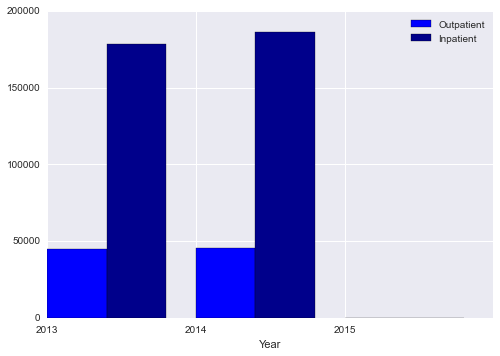

In [44]:
plt.bar(ct.index.values, ct[True], width=0.4, color='blue', label='Outpatient')
plt.bar(ct.index.values + 0.4, ct[False], width=0.4, color='darkblue', label='Inpatient')
plt.xticks([2013, 2014, 2015], ['2013', '2014', '2015'])
plt.xlabel('Year')

plt.legend()

## Summary statistics of different predictor columns



In [10]:
train_data[input_columns].describe()

,AndningsfrekvensStatusID,SaturationStatusID,KroppstemperaturStatusID,BlodtryckSystolisktOvreStatusID,BlodtryckDiastolisktNedreStatusID,GCSOgonoppningStatusID,GCSMotorisktStatusID,GCSVerbaltStatusID,StridorStatusID,PulsfrekvensRegelbundenStatusID,PulsfrekvensOregelbundenStatusID,MedvetandegradRettsStatusID,SaturationMedSyrgasStatusID,Alder
count,409393.000000,409393.000000,409393.000000,409393.000000,409393.000000,409393.000000,409393.000000,409393.000000,409393.000000,409393.000000,409393.000000,409393.000000,409393.000000,409393.000000
mean,-2.216665,3.936990,5.995642,4.483956,6.802857,-9.535688,-9.454795,-9.399919,5.206821,15.999135,-8.320015,16.175416,-9.029214,36.809782
std,6.233143,8.326046,10.033086,13.738789,16.257596,4.168803,4.861398,5.378215,23.329732,27.069971,9.948612,31.474653,8.180108,27.100202
min,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000
25%,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,11.769841
50%,2.000000,9.000000,12.000000,17.000000,21.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,34.095887
75%,2.000000,9.000000,12.000000,17.000000,23.000000,-10.000000,-10.000000,-10.000000,41.000000,44.000000,-10.000000,54.000000,-10.000000,58.901345
max,5.000000,9.000000,14.000000,19.000000,24.000000,28.000000,34.000000,39.000000,41.000000,47.000000,53.000000,57.000000,60.000000,113.983534


## Distribution of predictor columns by inpatient status

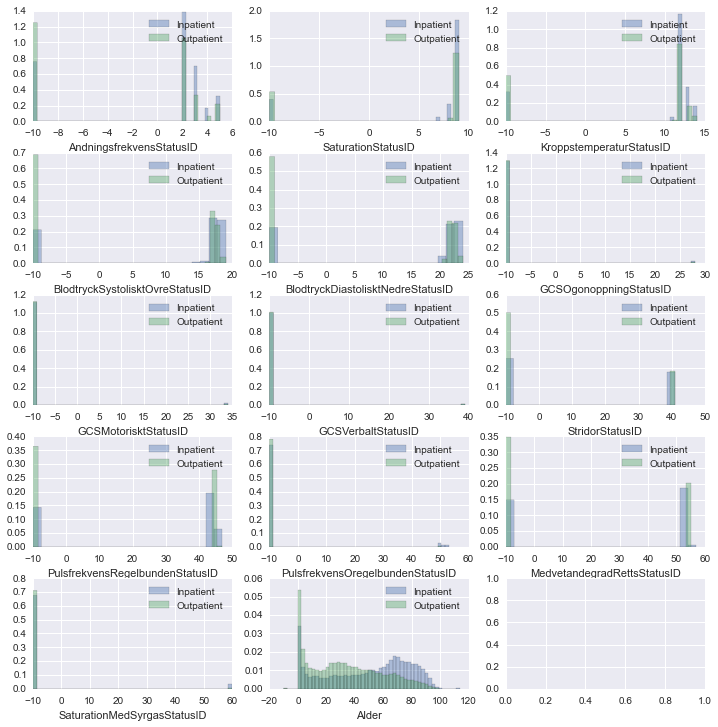

In [11]:
def plot_column(ax, col):
    sns.distplot(train_data[col][train_data.Inpatient == 1], kde=False, ax=ax, label='Inpatient', norm_hist=True)
    sns.distplot(train_data[col][train_data.Inpatient == 0], kde=False, ax=ax, label='Outpatient', norm_hist=True)
    ax.legend()

fig, axes = plt.subplots(nrows=5, ncols=3, sharex=False, sharey=False, figsize=(10, 10))
fig.tight_layout()

for ax, col in zip(axes.ravel(), input_columns):
    plot_column(ax, col)

Almost all columns, have substantially different distributions for both cases.

## Correlation heatmap